In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import pickle
import visualization
import jax.numpy as jnp

In [2]:
def convert_result(result):
    # todo better use a dictionary, because semantics of the tensor are lost.
    # [total_samples, sample_times_mean, sample_times_std, sample_times, num_chains]
    total_samples = jnp.array(result["samples_per_chain"] * result["num_chains"] + result["num_warmup"])[jnp.newaxis]
    sample_times = jnp.array(result["times"]) / total_samples
    sample_times = jnp.concatenate([sample_times], axis=-1)
    sample_times_mean = jnp.mean(sample_times)[jnp.newaxis]
    sample_times_std = jnp.std(sample_times)[jnp.newaxis]
    num_chains = jnp.array(result["num_chains"])[jnp.newaxis]
    jresult = jnp.concatenate([total_samples, sample_times_mean, sample_times_std, sample_times, num_chains], axis=0)
    return jresult

# single core torch
jresults_torch = []
for samples_per_chain in [2**2, 2**4, 2**6, 2**8, 2**10, 2**12, 2**14]:
    fname = "result_{}_{}_{}_{}_{}.pkl".format("torch", 1024, samples_per_chain, 1, 20)
    result = pickle.load(open("output/{}".format(fname), "rb"))
    jresult = convert_result(result)
    jresults_torch.append(jresult)
jresults_torch = jnp.array(jresults_torch)

# single core jax
jresults_jax = []
for samples_per_chain in [2**2, 2**4, 2**6, 2**8, 2**10, 2**12, 2**14, 2**16, 2**18]:
    fname = "result_{}_{}_{}_{}_{}.pkl".format("jax", 1024, samples_per_chain, 1, 20)
    result = pickle.load(open("output/{}".format(fname), "rb"))
    jresult = convert_result(result)
    jresults_jax.append(jresult)
jresults_jax = jnp.array(jresults_jax)

# parallel jax
jresults_jax_par = []
for samples_per_chain in [2**2, 2**4, 2**6, 2**8, 2**10, 2**12, 2**14, 2**16, 2**18]:
    fname = "result_{}_{}_{}_{}_{}.pkl".format("jax", 1024, samples_per_chain, 4, 20)
    result = pickle.load(open("output/{}".format(fname), "rb"))
    jresult = convert_result(result)
    jresults_jax_par.append(jresult)
jresults_jax_par = jnp.array(jresults_jax_par)

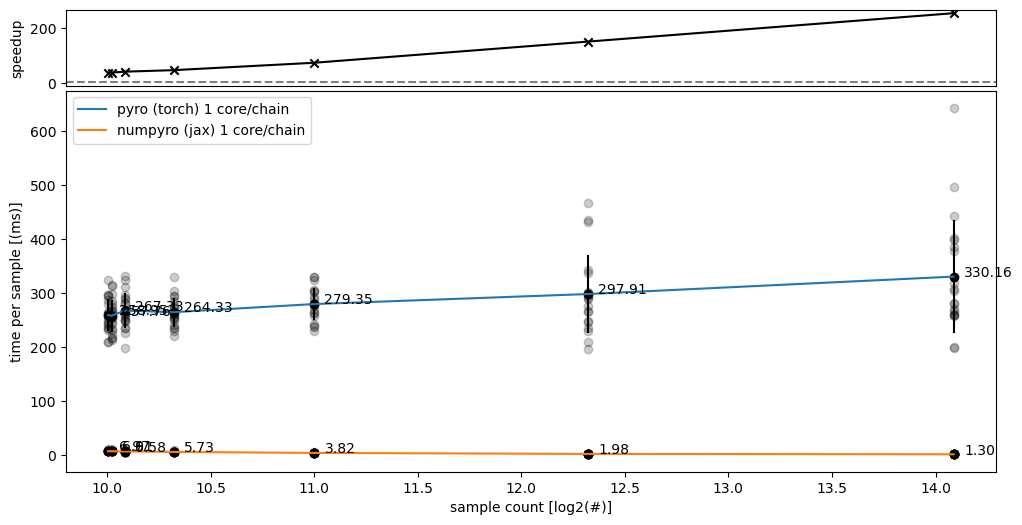

In [3]:
speed_comparison_figure = visualization.SpeedComparisonFigure(
    settings=visualization.SpeedComparisonSettings(sample_transformation="log2", time_transformation="none")
)

speed_comparison_figure.clear()
speed_comparison_figure.plot_acc(data=jresults_torch, label="pyro (torch) 1 core/chain")
speed_comparison_figure.plot_acc(data=jresults_jax[:7], label="numpyro (jax) 1 core/chain")

# speedup
differences = jresults_torch[:, 1] / jresults_jax[:7, 1]
speed_comparison_figure.plot_acc(data=jnp.stack([jresults_torch[:, 0], differences], axis=-1), label="numpyro (jax) 1 core", speedup=True)

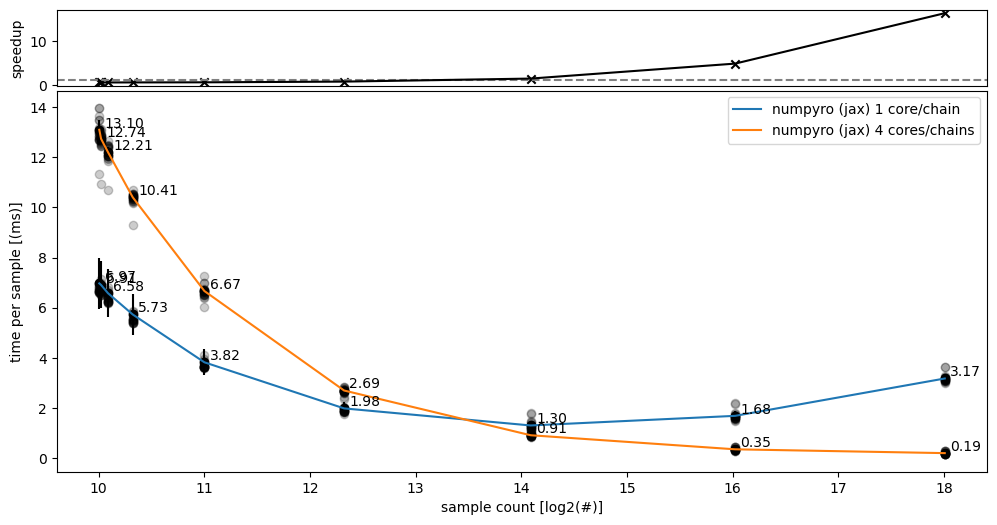

In [4]:
speed_comparison_figure.clear()
speed_comparison_figure.plot_acc(data=jresults_jax[:], label="numpyro (jax) 1 core/chain")
speed_comparison_figure.plot_acc(data=jresults_jax_par[:], label="numpyro (jax) 4 cores/chains")
# speedup
differences = jresults_jax[:, 1] / jresults_jax_par[:, 1]
speed_comparison_figure.plot_acc(data=jnp.stack([jresults_jax[:, 0], differences], axis=-1), label="numpyro (jax) 1 core", speedup=True)